In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load hasil preprocessing
merged = pd.read_csv("merged_data.csv")
merged['Date'] = pd.to_datetime(merged['Date'])


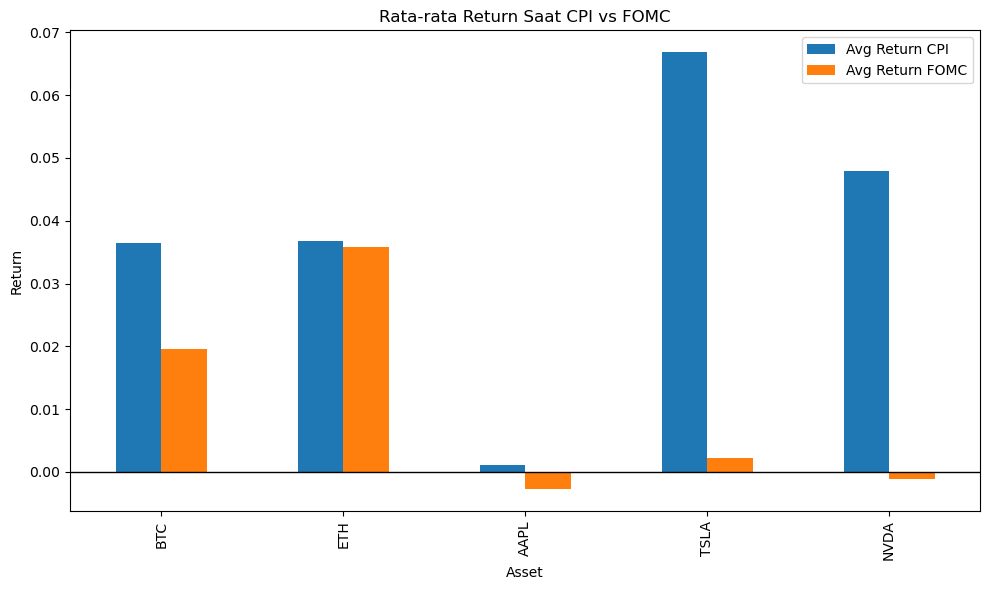

In [2]:
# Pisahkan event CPI dan FOMC
cpi_data = merged[merged['Event'] == 'CPI']
fomc_data = merged[merged['Event'] == 'FOMC']

# Kolom return
return_cols = ['BTC_ret', 'ETH_ret', 'AAPL_ret', 'TSLA_ret', 'NVDA_ret']

# Hitung rata-rata return masing-masing
avg_cpi = cpi_data[return_cols].mean().reset_index(name='Avg Return CPI')
avg_fomc = fomc_data[return_cols].mean().reset_index(name='Avg Return FOMC')

# Gabungkan
compare_df = avg_cpi.merge(avg_fomc, left_on='index', right_on='index').rename(columns={'index': 'Asset'})
compare_df['Asset'] = compare_df['Asset'].str.replace('_ret', '')

# Plot
compare_df.set_index('Asset').plot(kind='bar', figsize=(10,6))
plt.title("Rata-rata Return Saat CPI vs FOMC")
plt.ylabel("Return")
plt.axhline(0, color='black', linewidth=1)
plt.tight_layout()
plt.show()


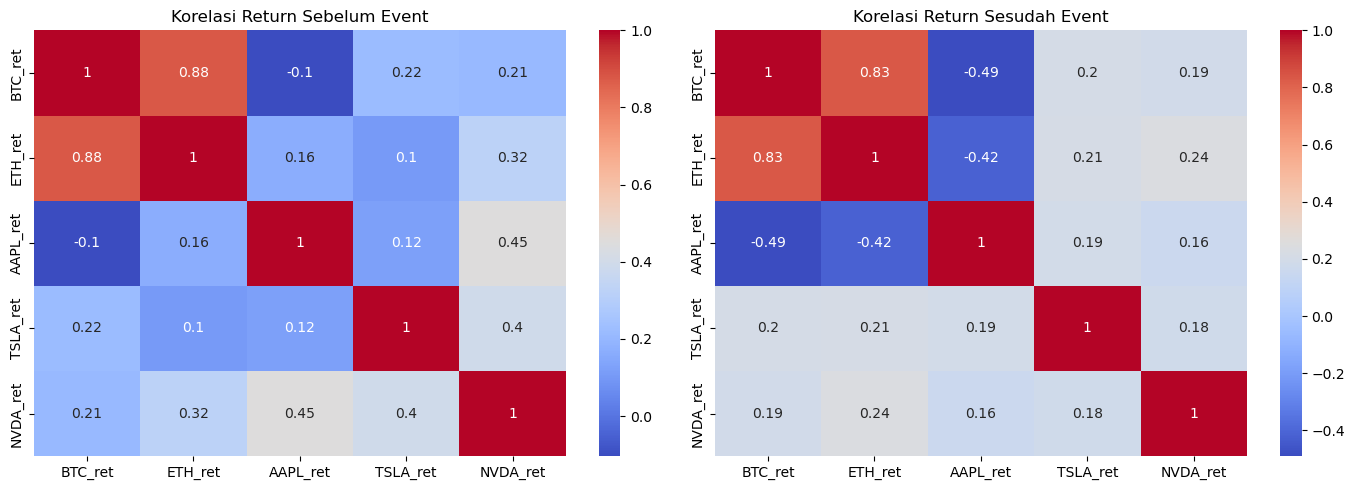

In [3]:
# Ambil 3 hari sebelum dan sesudah event
event_dates = merged[merged['is_event_day']]['Date']

# Buat list untuk menyimpan korelasi
before_corrs, after_corrs = [], []

for date in event_dates:
    # window
    before = merged[(merged['Date'] >= date - pd.Timedelta(days=3)) & (merged['Date'] < date)]
    after  = merged[(merged['Date'] > date) & (merged['Date'] <= date + pd.Timedelta(days=3))]
    
    # hanya kolom return
    before_corrs.append(before[return_cols].corr())
    after_corrs.append(after[return_cols].corr())

# Hitung rata-rata korelasi antar semua event
avg_before_corr = sum(before_corrs) / len(before_corrs)
avg_after_corr  = sum(after_corrs) / len(after_corrs)

# Plot perbandingan korelasi
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(avg_before_corr, ax=ax[0], annot=True, cmap='coolwarm')
ax[0].set_title("Korelasi Return Sebelum Event")

sns.heatmap(avg_after_corr, ax=ax[1], annot=True, cmap='coolwarm')
ax[1].set_title("Korelasi Return Sesudah Event")

plt.tight_layout()
plt.show()


In [4]:
# Hitung MA 5 hari
for col in ['BTC', 'ETH', 'AAPL', 'TSLA', 'NVDA']:
    merged[f'{col}_MA5'] = merged[col].rolling(window=5).mean()

# Deteksi breakout besar (harga tembus MA + return > 3%)
breakout_events = []

for i, row in merged.iterrows():
    for col in ['BTC', 'ETH', 'AAPL', 'TSLA', 'NVDA']:
        if pd.notna(row[col]) and pd.notna(row[f'{col}_MA5']) and pd.notna(row[f'{col}_ret']):
            if row[col] > row[f'{col}_MA5'] and row[f'{col}_ret'] > 0.03:
                breakout_events.append({
                    "Date": row['Date'],
                    "Asset": col,
                    "Return": row[f'{col}_ret'],
                    "Above MA5": True,
                    "Event": row['Event']
                })

breakout_df = pd.DataFrame(breakout_events)
breakout_df.head()


,Date,Asset,Return,Above MA5,Event
0,2025-01-16,BTC,0.038717,True,NaN
1,2025-01-16,ETH,0.068914,True,NaN
2,2025-01-17,TSLA,0.030641,True,NaN
3,2025-01-17,NVDA,0.030995,True,NaN
4,2025-01-18,BTC,0.041143,True,NaN


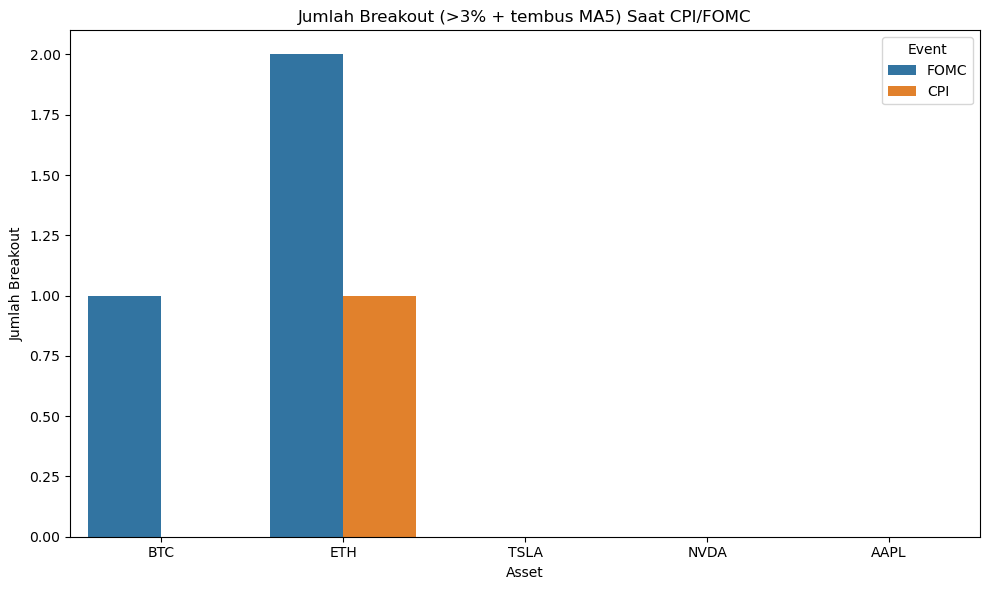

In [5]:
plt.figure(figsize=(10,6))
sns.countplot(data=breakout_df, x='Asset', hue='Event')
plt.title("Jumlah Breakout (>3% + tembus MA5) Saat CPI/FOMC")
plt.ylabel("Jumlah Breakout")
plt.tight_layout()
plt.show()
